<a href="https://colab.research.google.com/github/fregonalab/Walmart_Sales/blob/master/Walmart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# Importação das bibliotecas
# ---- Basics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# ---- Pré-processamento
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

# ---- Possíveis Modelos utilizados

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, ElasticNet, ElasticNetCV, HuberRegressor, LassoLars, BayesianRidge
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor

# ---- Cálculo das Métricas
from sklearn import metrics

# Eliminar warnings
import warnings
warnings.filterwarnings('ignore')

In [20]:
#Funções construidas anteriormente para facilitar processos comuns ao pré-processamento dos dados

#Desenhar box-plots para todas as variáveis
def draw_boxplots(df, selected_features):
  n = len(selected_features)
  fig = plt.figure(constrained_layout=True, figsize=(20, 30))
  gs = gridspec.GridSpec(int(n/3) + 1, 3, figure=fig)
  for i in range(n):
    k = int(i / 3)
    j = i % 3
    col = selected_features[i]
    ax = fig.add_subplot(gs[k, j])
    ax.set_title(col)
    ax.boxplot(df[col])

#Remoção de outliers por interquartis - boxplots
def replace_outliers(df, var_names):
  for var_name in var_names:
    # calculating Q1 and Q3
    Q1 = df.loc[:,var_name].quantile(0.25)
    Q3 = df.loc[:,var_name].quantile(0.75)
    # calculating Interquartile IQR
    IQR = Q3 - Q1
    # build up filter
    filter_up = (df.loc[:,var_name] > Q3 + 1.5 *IQR)
    # apply up filter on df
    df.loc[filter_up, var_name] = Q3 + 1.5 *IQR
    # build down filter
    filter_down = (df.loc[:,var_name] < Q1 - 1.5 * IQR)
    # apply down filter on df
    df.loc[filter_down, var_name] = Q1 - 1.5 * IQR


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_features = pd.read_csv('/content/drive/MyDrive/walmart/features.csv')
df_stores = pd.read_csv('/content/drive/MyDrive/walmart/stores.csv')
df_sales = pd.read_csv('/content/drive/MyDrive/walmart/train.csv')

## 1.1 Tratamento dos dados

Para facilitar a limpeza vamos juntar todos os bancos de dados primeiro!

In [ ]:
df_features.head(2)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True


In [ ]:
df_stores.head(2)

,Store,Type,Size
0,1,A,151315
1,2,A,202307


In [ ]:
df_sales.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True


## 1.2 Juntar os bancos de dados

In [4]:
#Junção entre df e df_stores pelo id_client
df = pd.merge(df_features, df_stores, right_on='Store', left_on='Store', how='left', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

In [5]:
#Junção entre df_compras, df_clientes e df_lojas pelo id_loc
df = pd.merge(df, df_sales, right_on=['Store','Date'], left_on=['Store','Date'], how='right', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

In [ ]:
#Nulos no banco de dados antes 
df.isnull().sum()/df.shape[0]

Store           0.000000
Date            0.000000
Temperature     0.000000
Fuel_Price      0.000000
MarkDown1       0.642572
MarkDown2       0.736110
MarkDown3       0.674808
MarkDown4       0.679847
MarkDown5       0.640790
CPI             0.000000
Unemployment    0.000000
IsHoliday       0.000000
Type            0.000000
Size            0.000000
Dept            0.000000
Weekly_Sales    0.000000
dtype: float64

## 1.2 Tratamento de nulos

Após a junção dos dados, tivemos nulos em diversas váriaveis. Conforme o entendimento de negócio, os atributos 'MarkDowns' são as quantidades percentuais de promoções, portanto os NA's são zero, ou seja, lojas que não tiveram promoções.

In [6]:
#Preencher nulos com valores médios na variável CPI
df = df.fillna(0)

In [ ]:
#Nulos no banco de dados após tratamento
df.isnull().sum()/df.shape[0]

Store           0.0
Date            0.0
Temperature     0.0
Fuel_Price      0.0
MarkDown1       0.0
MarkDown2       0.0
MarkDown3       0.0
MarkDown4       0.0
MarkDown5       0.0
CPI             0.0
Unemployment    0.0
IsHoliday       0.0
Type            0.0
Size            0.0
Dept            0.0
Weekly_Sales    0.0
dtype: float64

## 1.3 Formatação das variáveis

In [7]:
#Categóricas
df.loc[:, ['IsHoliday', 'Type', 'Dept', 'Store']] = df.loc[:, ['IsHoliday', 'Type', 'Dept', 'Store']].astype('category')

In [8]:
#Numéricas
df['Size'] = df['Size'].astype('float64')

In [9]:
#Data
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')

In [ ]:
df.dtypes

Store                 category
Date            datetime64[ns]
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
IsHoliday             category
Type                  category
Size                   float64
Dept                  category
Weekly_Sales           float64
dtype: object

## 1.4 Remoção de Outliers

In [18]:
df.describe()

,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Weekly_Sales
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,136727.915739,15981.258123
std,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,60980.583328,22711.183519
min,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000,-4988.940000
25%,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000,2079.650000
50%,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,140167.000000,7612.030000
75%,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,202505.000000,20205.852500
max,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000,693099.360000


Claramente, em algumas váriaveis existe a presença de outliers!

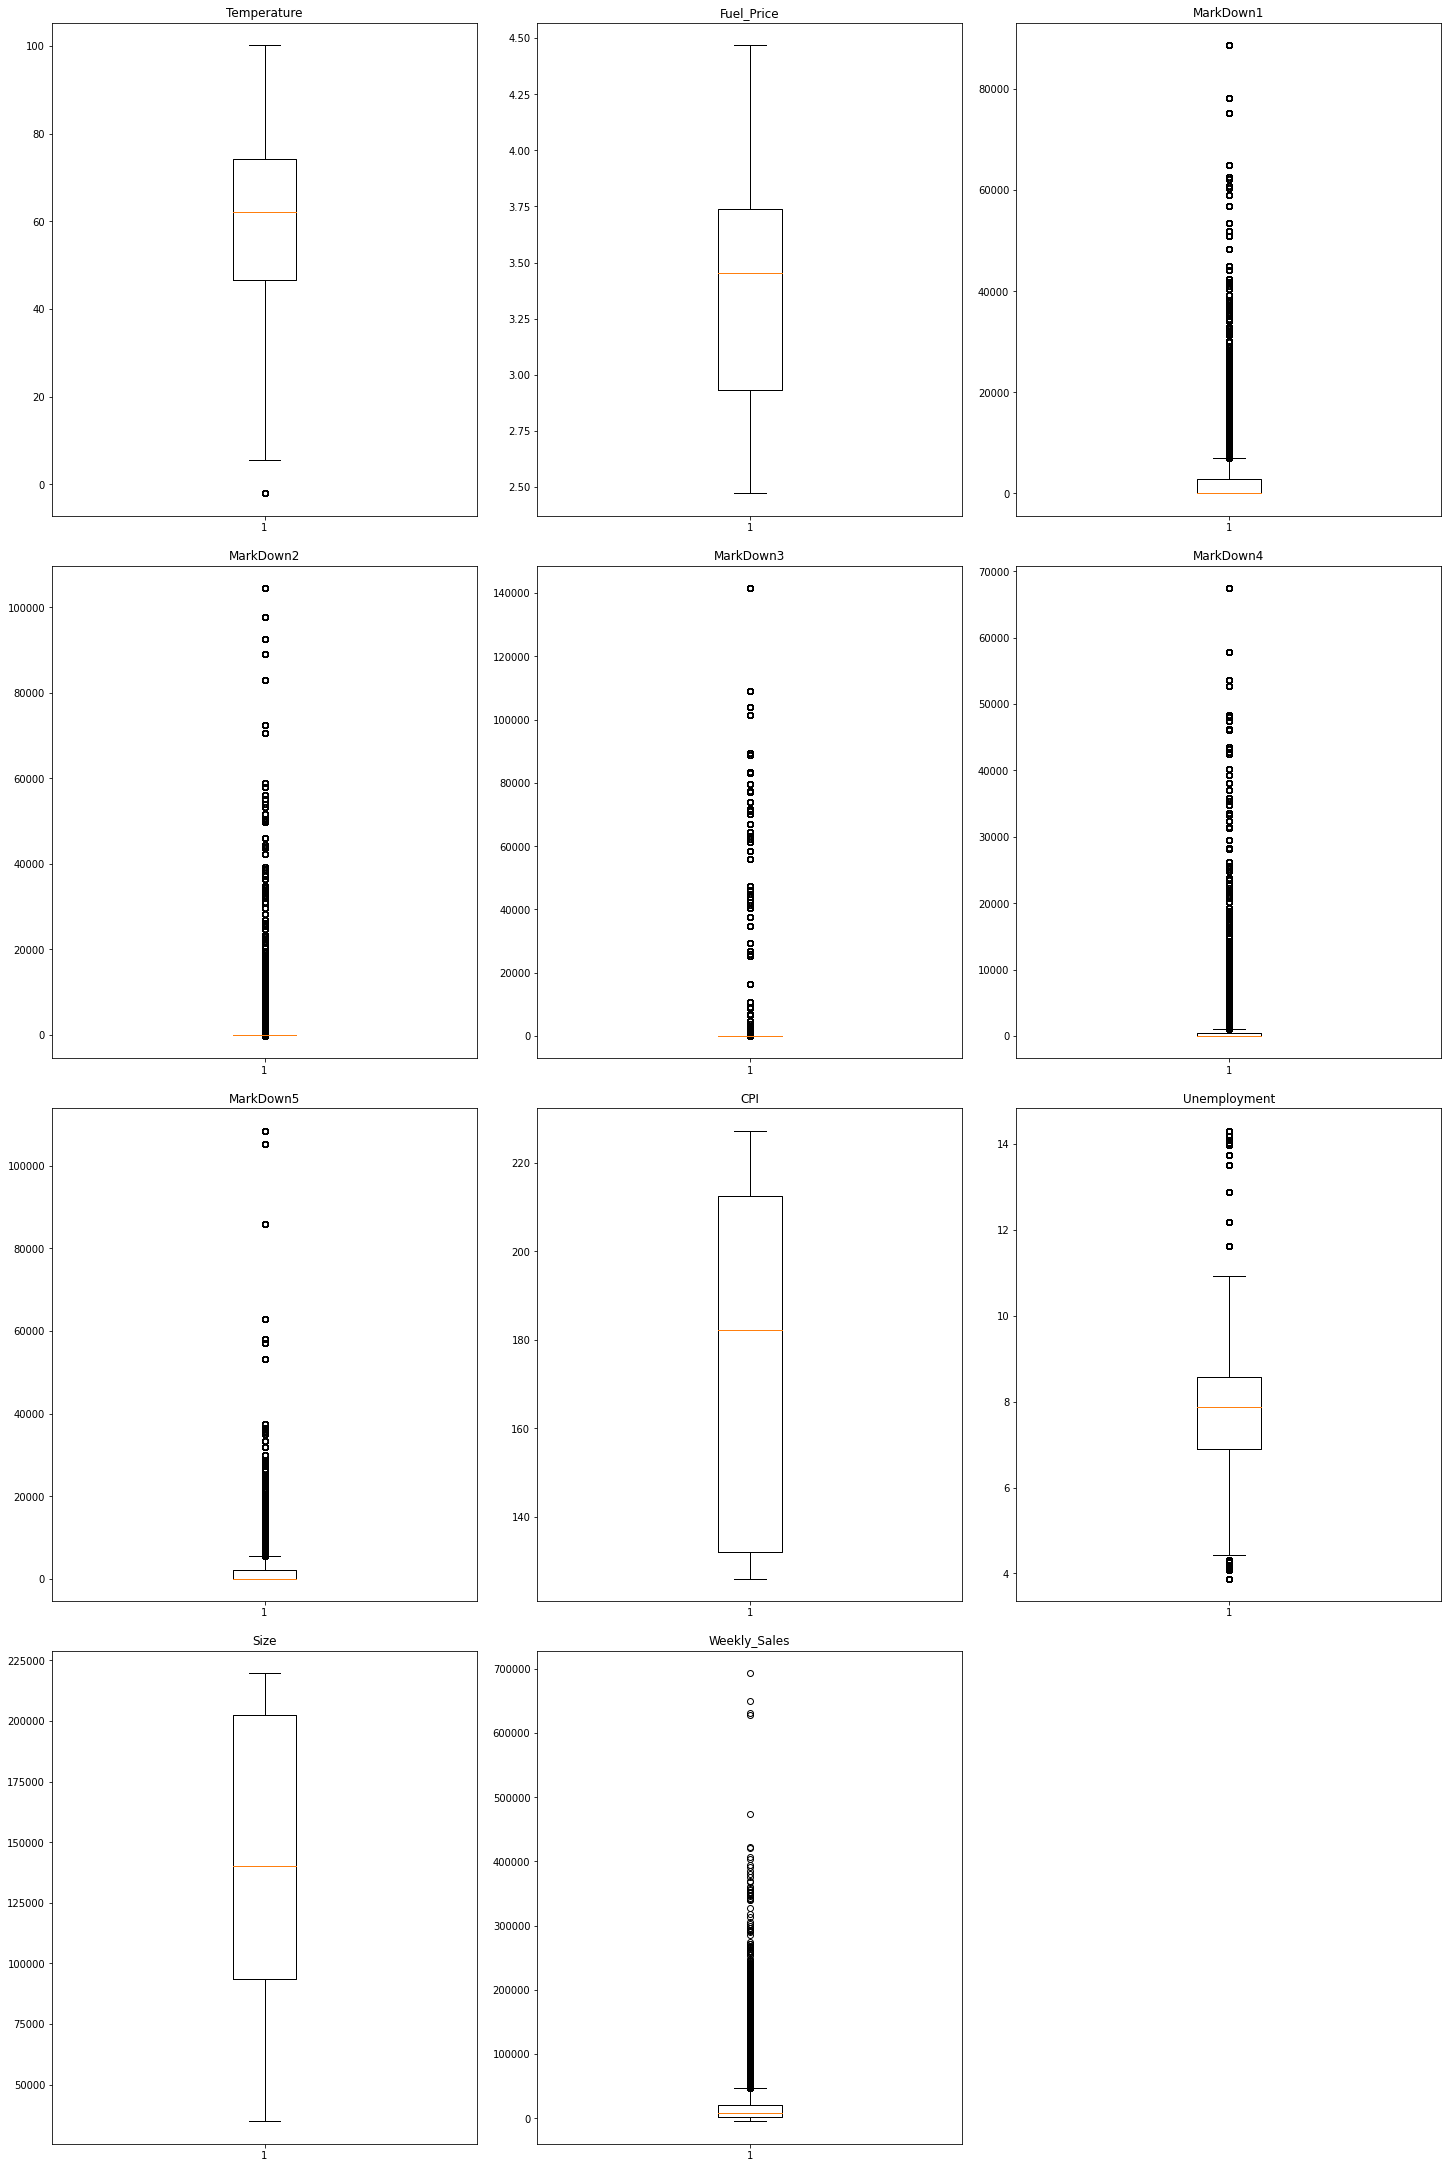

In [30]:
#Checando a presença de outliers
draw_boxplots(df, df.select_dtypes("number").columns)

In [35]:
#Substituindo os outliers pela definição de boxplots
replace_outliers(df, df.select_dtypes("number").columns)

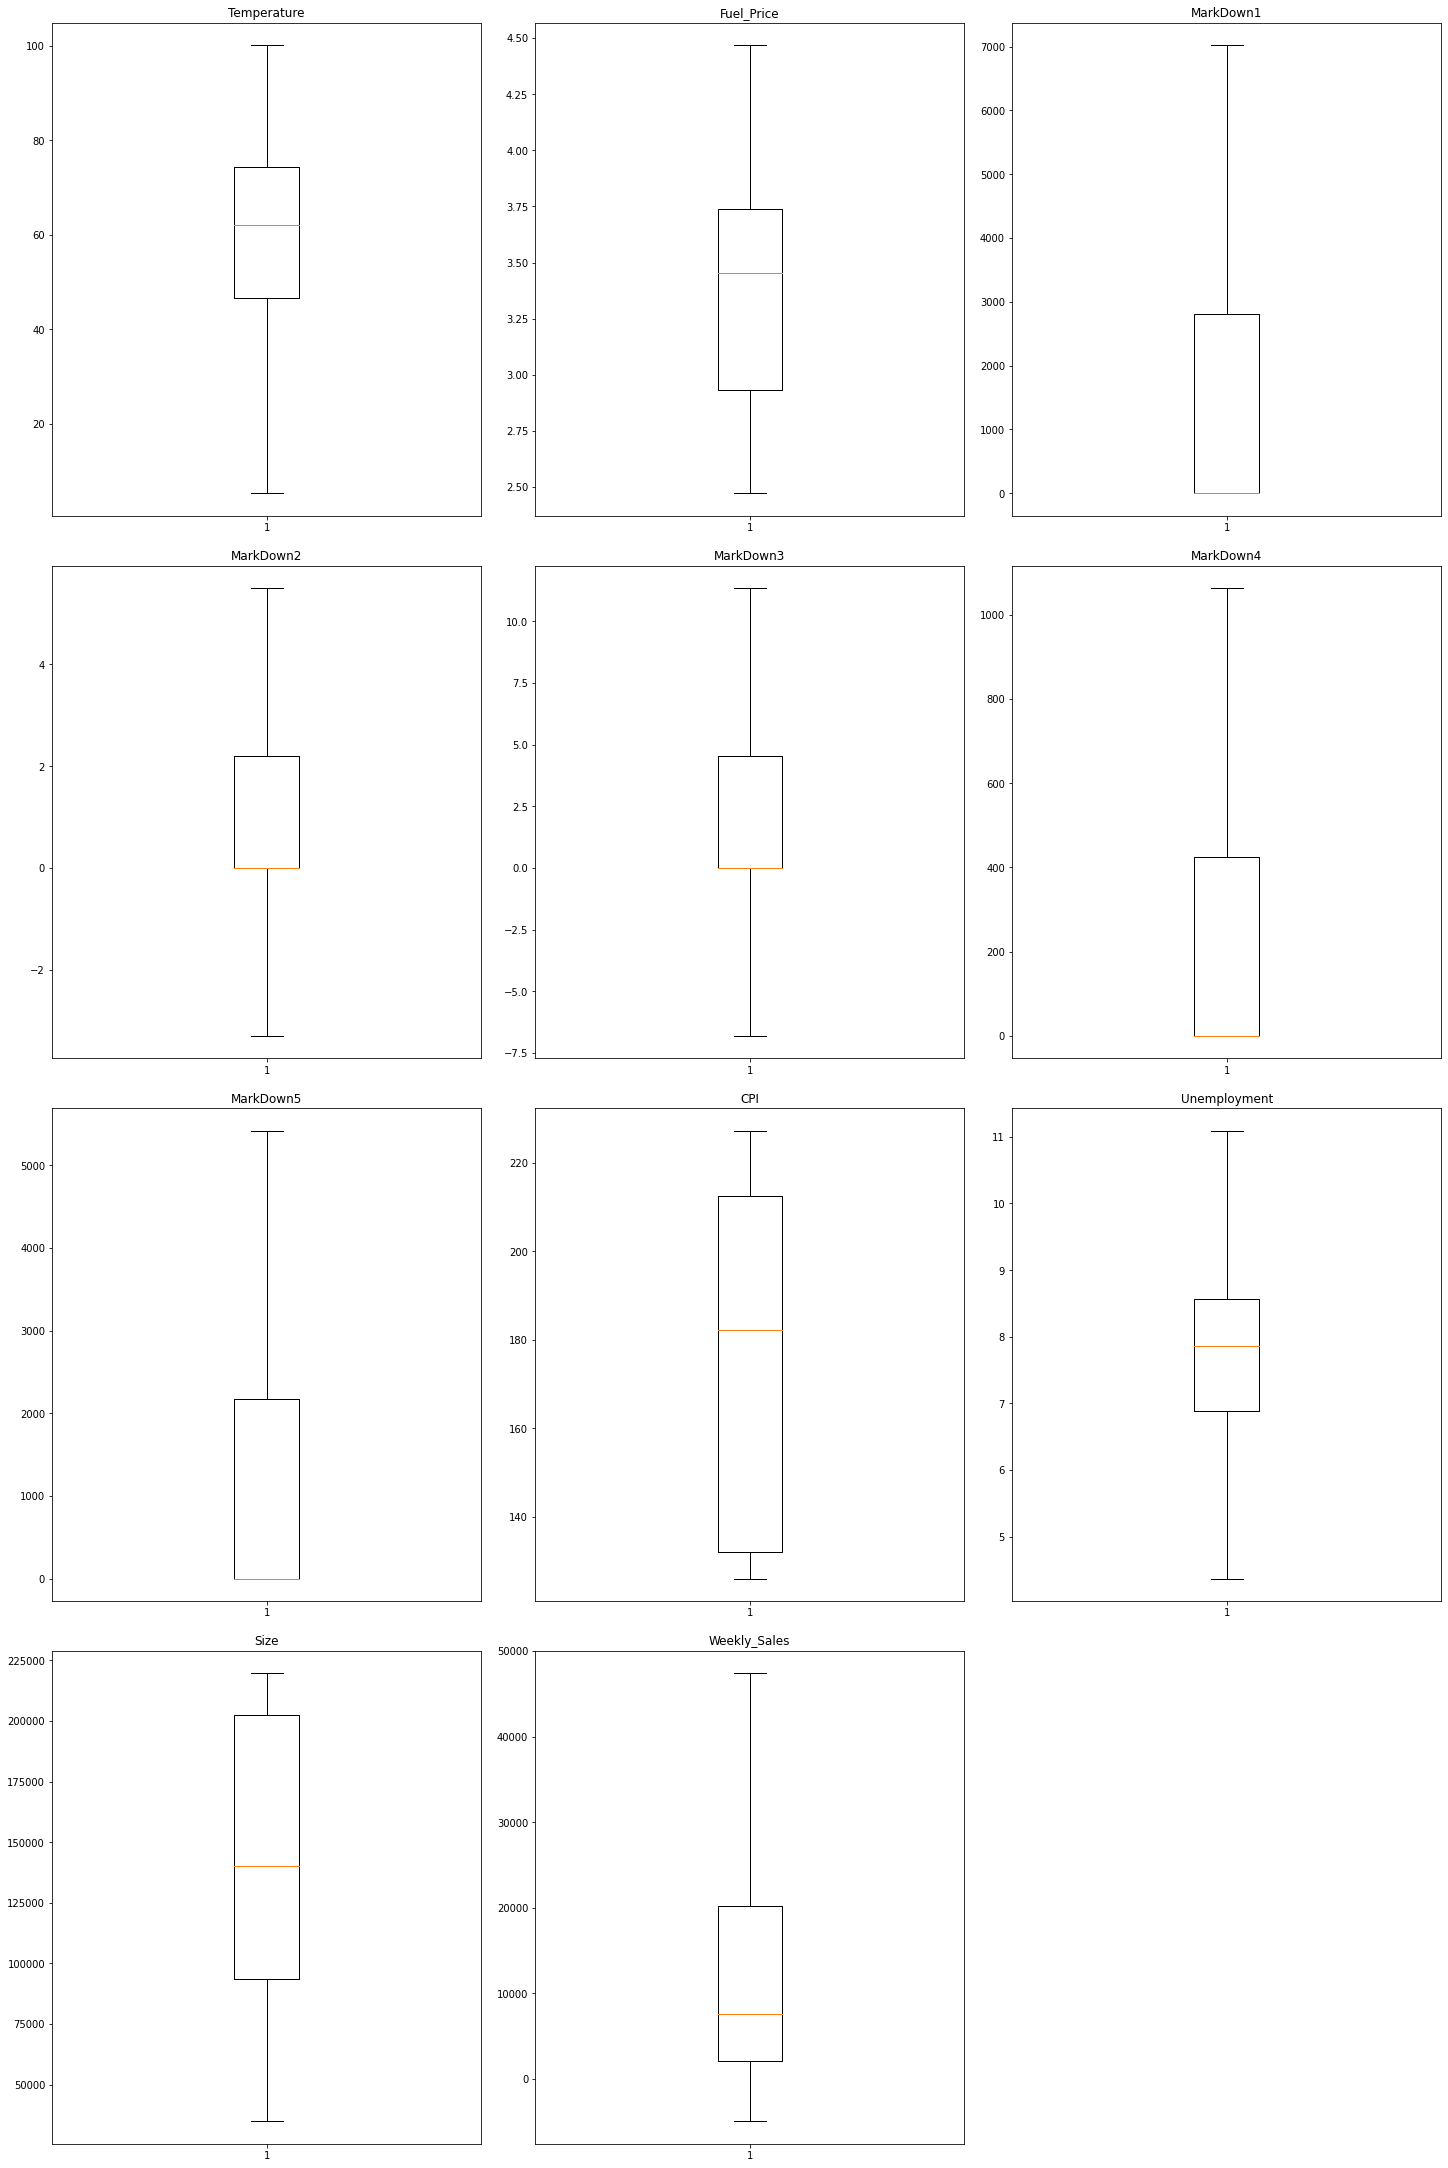

In [39]:
#Checando novamente a presença de outliers após remoção
draw_boxplots(df, df.select_dtypes("number").columns)

## 1.5 Escalando as variáveis numéricas

In [40]:
#Definindo o escalador
scaler = StandardScaler()

#Selecionando nomes das colunas
col_num = list(df.select_dtypes('number').columns)
col_num.remove('Weekly_Sales')

#Fitando o modelo nos dados
scaler.fit(df[col_num])

#Alterando os valores do dataset original
df_num = pd.DataFrame(scaler.transform(df[col_num]),columns=col_num)

## 1.6 One-hot encoding as variáveis categóricas

In [41]:
#Tratando as variáveis categoricas
df_cat = pd.get_dummies(data = df[['Type','IsHoliday','Dept']], drop_first = True) 

In [ ]:
df_cat.shape

(421570, 83)

## 1.7 Concatenando datasets

In [42]:
df_clean = pd.concat([df['Weekly_Sales'], df_num, df_cat], axis = 1)

## 1.8 Validação do Pré-tratamento

In [43]:
#Atributos e nomes dos atributos
df_clean.head(1)

,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,...,Dept_90,Dept_91,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99
0,24924.5,-0.964062,-1.720834,-0.607854,-0.57483,-0.603841,-0.596633,-0.635024,1.018774,0.183066,...,0,0,0,0,0,0,0,0,0,0


In [44]:
#Nulos
df_clean.isnull().sum()/df_clean.shape[0]

Weekly_Sales    0.0
Temperature     0.0
Fuel_Price      0.0
MarkDown1       0.0
MarkDown2       0.0
               ... 
Dept_95         0.0
Dept_96         0.0
Dept_97         0.0
Dept_98         0.0
Dept_99         0.0
Length: 94, dtype: float64

In [45]:
#Outros erros
df_clean.tail()

,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,...,Dept_90,Dept_91,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99
421565,508.37,0.259635,1.387032,1.101243,1.744573,-0.279740,1.878585,1.090661,0.531461,0.568935,...,0,0,0,0,0,0,0,0,1,0
421566,628.10,0.260177,1.360860,1.285082,-0.574830,1.848522,1.878585,0.593021,0.535467,0.557586,...,0,0,0,0,0,0,0,0,1,0
421567,1061.02,-0.304773,1.393575,0.125909,-0.574830,1.100930,0.798601,1.459225,0.539472,0.557586,...,0,0,0,0,0,0,0,0,1,0
421568,760.01,-0.196337,1.325965,0.143816,-0.574830,0.083253,0.422415,0.171856,0.539564,0.557586,...,0,0,0,0,0,0,0,0,1,0
421569,1076.80,-0.067298,1.136222,0.899562,1.744573,1.848522,-0.103231,-0.184569,0.539003,0.557586,...,0,0,0,0,0,0,0,0,1,0


## 1.3 Treinamento do modelo - Amostra

### 1.3.1 Separação de treino e teste

In [46]:
df_amostra = df_clean.sample(n = 1000, random_state = 132)

In [47]:
X = df_amostra.drop('Weekly_Sales', axis = 1)
y = df_amostra['Weekly_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 45)

### 1.3.2 Escolha do melhor modelo

In [48]:
# Treinamento e validação dos Modelos

models = {
    'LinearReg': LinearRegression(),
    'RidgeReg': Ridge(),
    'LassoReg': Lasso(),
    'ElasticNetReg': ElasticNet(),
    'HuberReg': HuberRegressor(),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'LassoLars': LassoLars(),
    'BayesianRidge': BayesianRidge(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'SVM_RBF':SVR(kernel='rbf'),
    'SVM_POLY':SVR(kernel='poly'),
    'SVM_LINEAR':SVR(kernel='linear',max_iter=10**4),
    'SVM_SIG':SVR(kernel='sigmoid'),
    'SGDRegressor':SGDRegressor(),
    'RandomForestRegressor':RandomForestRegressor(),
    'AdaBoostRegressor':AdaBoostRegressor(),
    'GradientBoostingRegressor':GradientBoostingRegressor(),
    'ExtraTreesRegressor':ExtraTreesRegressor()
}

#Training all models
for model in models.values():
    model.fit(X_train, y_train);

#Validação dos modelos

MSE = []
MAE = []
nome = []
for name, model in models.items():
    nome.append(name)
    y_pred = model.predict(X_test)
    MSE.append(np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
    MAE.append(metrics.mean_absolute_error(y_test,y_pred))

In [49]:
# Melhores modelos a partir das métricas de erro
teste = pd.DataFrame({'Modelo': nome, 'MSE': MSE, 'MAE':MAE})
teste.nsmallest(10,['MSE'])

,Modelo,MSE,MAE
18,ExtraTreesRegressor,8027.668926,5291.848623
15,RandomForestRegressor,8800.896625,5952.242563
1,RidgeReg,8826.423620,6846.813284
8,BayesianRidge,8832.163192,6830.352906
5,LassoCV,8882.434401,6839.729823
7,LassoLars,8887.053370,6844.097674
2,LassoReg,8915.857517,6878.729659
0,LinearReg,8944.531005,6891.380390
14,SGDRegressor,8951.663322,6939.273947
4,HuberReg,9175.315565,6456.436545


A métrica escolhida para filtrar os melhores modelos foi o MSE, pois não queremos que a previsão do faturamento semanal "Weekly_Sales" seja muito discrepante. Pequenos erros são aceitáveis, porém grandes erros não.

### 1.3.3 Ajuste dos hiperparâmetros - amostra

In [50]:
#Utilizando ExtraTreesRegressor como modelo
ETR = ExtraTreesRegressor()
parameters = {'max_depth': [None, 10, 40, 100],
              'min_samples_split': [2, 3, 4, 5],
              'min_samples_leaf': [1, 2, 5, 10],
              'min_weight_fraction_leaf' : [0, 0.5, 1, 1.5],
              'max_features': [1, 4, 10, 60, 100],
              'min_impurity_decrease': [0, 0.5, 1, 1.5],
                 }

reg = GridSearchCV(estimator = ETR, param_grid = parameters, cv = 2, n_jobs=-1)
reg.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=ExtraTreesRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 40, 100],
                         'max_features': [1, 4, 10, 60, 100],
                         'min_impurity_decrease': [0, 0.5, 1, 1.5],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 3, 4, 5],
                         'min_weight_fraction_leaf': [0, 0.5, 1, 1.5]})

In [51]:
#Parâmetros do melhor modelo
reg_best = reg.best_estimator_
reg_best

ExtraTreesRegressor(max_depth=40, max_features=60, min_impurity_decrease=1,
                    min_weight_fraction_leaf=0)

In [52]:
# Cálculo das Melhores métricas atingidas no Mini-Case
reg_best.fit(X_train,y_train)
y_pred = reg_best.predict(X_test)
print('-------------------------')
print(name + "\n MSE: {:.4F}\n MAE: {:.4F}".format(np.sqrt(metrics.mean_squared_error(y_test,y_pred)),metrics.mean_absolute_error(y_test,y_pred)))
print('-------------------------')

-------------------------
ExtraTreesRegressor
 MSE: 7968.4399
 MAE: 5352.2068
-------------------------


## 1.4 Treinamento do modelo - Macro

In [56]:
#Separando dataset completo em conjunto de treino e teste
X = df_clean.drop('Weekly_Sales', axis = 1)
y = df_clean['Weekly_Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 2)

In [59]:
#Utilizando ExtraTreesRegressor com os hiperparâmetros ajustados
ETR = ExtraTreesRegressor(max_depth=40, max_features=60, min_impurity_decrease=1, min_weight_fraction_leaf=0)
ETR.fit(X_train, y_train)

ExtraTreesRegressor(max_depth=40, max_features=60, min_impurity_decrease=1,
                    min_weight_fraction_leaf=0)

In [60]:
# Cálculo das Melhores métricas atingidas no Mini-Case
y_pred = ETR.predict(X_test)
print('-------------------------')
print(name + ":\n MSE: {:.4F}\n MAE: {:.4F}".format(np.sqrt(metrics.mean_squared_error(y_test,y_pred)), metrics.mean_absolute_error(y_test,y_pred)))
print('-------------------------')

-------------------------
ExtraTreesRegressor:
 MSE: 4189.5201
 MAE: 2392.2780
-------------------------
